In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../src")

from preprocessing import load_unsw_data, preprocess_data
from anomaly import run_isolation_forest, run_one_class_svm
from selection import remove_correlated_features, unsupervised_feature_selection, apply_pca
from tuning import tune_isolation_forest, tune_one_class_svm
from sklearn.metrics import roc_auc_score

In [2]:
print("[1] Loading UNSW-NB15 dataset...")
df = load_unsw_data("../data/")
X_train, X_test, y_train, y_test = preprocess_data(df)

print(f"[✔] Dataset loaded. Train: {X_train.shape}, Test: {X_test.shape}")

[1] Loading UNSW-NB15 dataset...
[✔] Dataset loaded. Train: (1441590, 48), Test: (617825, 48)



[2] Performing Feature Selection and PCA...
[✔] Dropped 8 correlated features.
[✔] Selected top 25 features using RandomForest importance.
[✔] Applied PCA → 10 components explain 75.26% variance.
[✔] Final Feature Shape: (1441590, 10)


C:\Users\hp\AppData\Local\Temp\ipykernel_26552\3890242660.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.nlargest(10).values, y=importances.nlargest(10).index, palette="coolwarm")


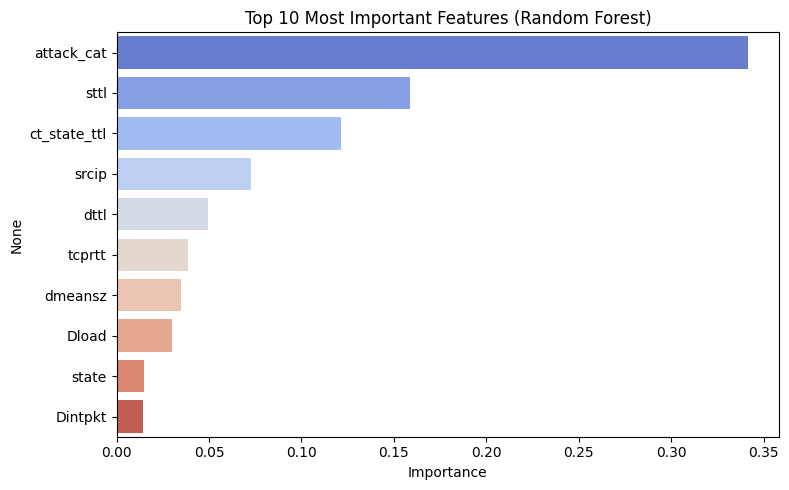

In [ ]:
print("\n[2] Performing Feature Selection and PCA...")

# Remove correlated features
X_train_corr, _ = remove_correlated_features(X_train)
X_test_corr = X_test[X_train_corr.columns]
    
X_train_fs = unsupervised_feature_selection(X_train_corr)
X_test_fs = X_test_corr[X_train_fs.columns]

# Apply PCA for anomaly modeling
X_train_pca, X_test_pca, _ = apply_pca(X_train_fs, X_test_fs, n_components=15)

print(f"[✔] Final Feature Shape: {X_train_pca.shape}")

In [ ]:
print("\n[3] Parameter Tuning Anomaly Detection Models...")

# Isolation Forest
best_params_if, _ = tune_isolation_forest(X_test_pca, y_test)

# One-Class SVM
best_params_svm, _ = tune_one_class_svm(X_test_pca, y_test)

In [ ]:
print("\n[4] Evaluating Anomaly Detection Models...")

# Isolation Forest
from sklearn.ensemble import IsolationForest
iso = IsolationForest(random_state=42, **best_params_if)
preds_if = iso.fit_predict(X_test_pca)
preds_if = np.where(preds_if == -1, 1, 0)
auc_if = roc_auc_score(y_test, preds_if)
print(f"[✔] Final Isolation Forest ROC-AUC: {auc_if:.3f}")


[3] Tuning and Evaluating Anomaly Detection Models...
[✔] Best Isolation Forest AUC: 0.948
Best Params: {'contamination': 0.1, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 200}
[✔] Final Isolation Forest ROC-AUC: 0.948


In [ ]:
# One-Class SVM
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(**best_params_svm)
preds_svm = ocsvm.fit_predict(X_test_pca)
preds_svm = np.where(preds_svm == -1, 1, 0)
auc_svm = roc_auc_score(y_test, preds_svm)
print(f"[✔] Final One-Class SVM ROC-AUC: {auc_svm:.3f}")

In [1]:
results = pd.DataFrame([
    {"Model": "Isolation Forest", "ROC-AUC": auc_if},
    {"Model": "One-Class SVM", "ROC-AUC": auc_svm}
])

plt.figure(figsize=(7,5))
sns.barplot(x="Model", y="ROC-AUC", data=results, palette="viridis")
plt.title("Tuned Anomaly Detection Model Performance")
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()


NameError: name 'pd' is not defined

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap="coolwarm", s=8, alpha=0.6)
plt.title("PCA 2D Projection of Test Data (Normal vs Attack)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

In [ ]:
print("\n=== 🏁 Final Unsupervised Model Results ===")
print(results.to_string(index=False))
